In [1]:
from kneed import DataGenerator, KneeLocator
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
import scipy.io
import json
import numpy as np
from format_data import *
from utils import *
import pickle
from utils_tt import *
import glob
from kneed import DataGenerator, KneeLocator
from quick_extract import *
from get_data import *
from load_rhd import *
import matplotlib.pyplot as plt
from ExtractRecordings.manual.simple_sort import*
import pandas as pd
from PostProcessing.tools.utils import *
import csv
from format_data import *
import pandas as pd
from create_data import *
import os
import glob
import scipy.io
from delta_frequency import *
import math
from utils import *
from format_data import get_sem
from convert_positions_in_tones import *
import re
import json
import pickle
import os
import glob

In [2]:
t_pre = 0.2#0.2
t_post = 0.50#0.300
bin_width = 0.005
# Créer les bins de temps"
psth_bins = np.arange(-t_pre, t_post, bin_width)
#gc = np.arange(0, 32)

In [3]:
path = '/auto/data2/eTheremin/ALTAI/ALTAI_20240910_SESSION_00/headstage_0/'

In [4]:
neural = np.load(path+'filtered_neural_data.npy', allow_pickle=True)
#neural = np.load('/auto/data2/eTheremin/ALTAI/ALTAI_20240910_SESSION_00/neural_data.npy', allow_pickle=True)

In [5]:
neural = np.transpose(neural)

In [6]:
n = int(len(neural[0])/2)
print(n)

39561600


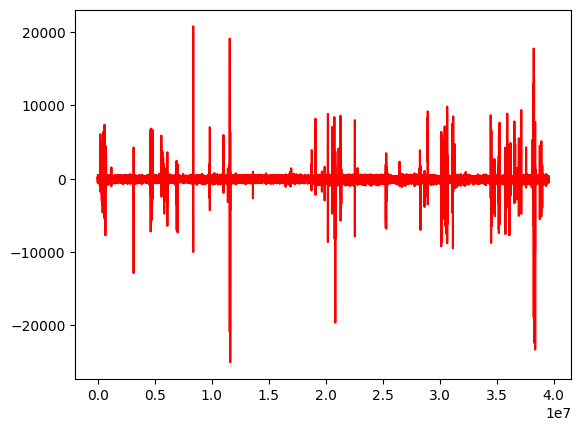

In [7]:
plt.plot(neural[26][:n], c='red')

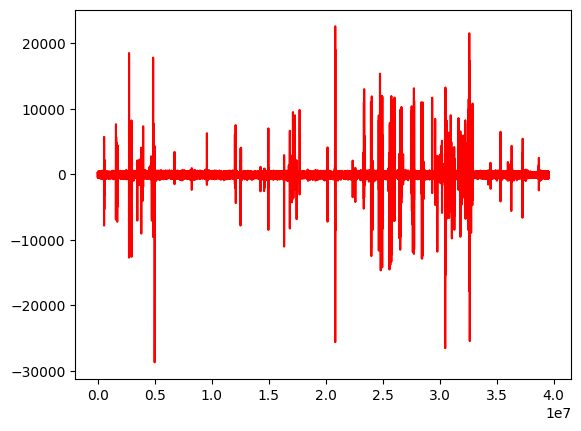

In [8]:
plt.plot(neural[26][n:], c='red')

In [9]:
def quick_extract(path, mode="relative", threshold=-3.7):
    root_dir = os.path.split(path)[0]
    data = ss.load_spike_data(path)
    data = np.transpose(data)
    channels = np.arange(data.shape[0])
    spike_times = np.empty(0, dtype=np.uint64)
    spike_clusters = np.empty(0, dtype=np.int32)
    assert mode in ("relative", "absolute"), "Mode is relative (from RMS calculation) or absolute (threshold in µV)."
    to_float = False
    if data.dtype == np.uint16:
        to_float = True
    if mode == "absolute":
        threshold = -60
    else:
        threshold = threshold
    for i, channel in tqdm(enumerate(channels)):
        if to_float:
            chan = np.multiply(0.195, (data[channel].astype(np.int32) - 32768))
            spk, _ = ss.thresholder(chan, mode, threshold=threshold)
        else:
            spk, _ = ss.thresholder(data[channel], mode, threshold=threshold)
        cluster = np.full_like(spk, i)
        spike_times = np.hstack((spike_times, spk))
        spike_clusters = np.hstack((spike_clusters, cluster))
    idx = np.argsort(spike_times)
    spike_times = spike_times[idx]
    spike_clusters = spike_clusters[idx]
    np.save(os.path.join(root_dir, "spike_times_fp.npy"), spike_times)
    np.save(os.path.join(root_dir, "spike_clusters_fp.npy"), spike_clusters)
    pass

In [10]:
quick_extract('/auto/data2/eTheremin/ALTAI/ALTAI_20240910_SESSION_00/headstage_0/filtered_neural_data.npy', threshold=4)

32it [01:01,  1.91s/it]


In [11]:
spk_times_fp = np.load('/auto/data2/eTheremin/ALTAI/ALTAI_20240910_SESSION_00/headstage_0/spike_times_fp.npy')
spk_clus_fp = np.load('/auto/data2/eTheremin/ALTAI/ALTAI_20240910_SESSION_00/headstage_0/spike_clusters_fp.npy')

In [12]:
spk_times = np.load('/auto/data2/eTheremin/ALTAI/ALTAI_20240910_SESSION_00/headstage_0/spike_times.npy')
spk_clus = np.load('/auto/data2/eTheremin/ALTAI/ALTAI_20240910_SESSION_00/headstage_0/spike_clusters.npy')

In [13]:

# Filtrer les éléments dont l'indice est 3
spk_26_fp = [spk_times_fp[i] for i in range(len(spk_clus_fp)) if spk_clus_fp[i] == 26]

spk_26 = [spk_times[i] for i in range(len(spk_clus)) if spk_clus[i] == 26]


In [14]:
print(len(spk_26_fp), len(spk_26))

1051942 1172974


In [51]:
quick_extract('/auto/data2/eTheremin/ALTAI/ALTAI_20240910_SESSION_00/headstage_0/filtered_neural_data.npy')

32it [00:56,  1.75s/it]


In [3]:
triggers_tr, tones_total_tr = get_triggers(path, analog_line=0)
triggers_pb, tones_total_pb = get_triggers(path, analog_line=1)

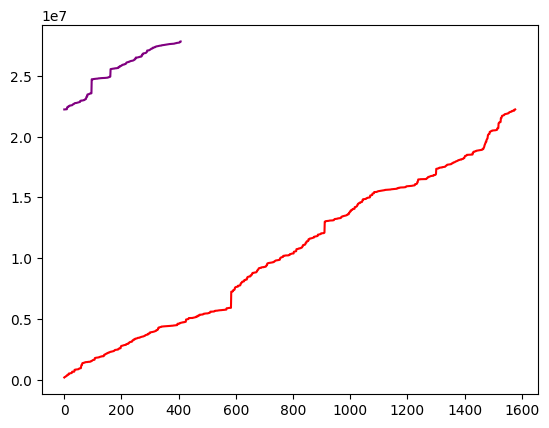

In [4]:
plt.plot(triggers_tr, c = 'red')
plt.plot(triggers_pb, c = 'purple')

In [5]:
gc = np.load(path+'headstage_0/good_clusters.npy')

In [6]:
gc

array([ 5, 27, 20,  6, 28, 29,  3,  8, 26])

In [4]:
dig = np.load('/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/dig_in.npy', allow_pickle=True)
an = np.load('/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/analog_in.npy', allow_pickle=True)

In [5]:
an_triggers = np.load(os.path.join(path, "analog_in.npy"))
an_times = ut.extract_analog_triggers_compat(an_triggers[0])

In [15]:
an1_times = ut.extract_analog_triggers_compat(an_triggers[1])
len(an_times)

7235

In [16]:
len(an1_times)

3742

In [11]:
def get_tracking_files(folder):
    # Trouver tous les fichiers qui comportent "tracking" dans leur nom
    all_files = glob.glob(os.path.join(folder, "tracking_0*.bin"))
    
    # Afficher les fichiers trouvés
    print("Files matching the pattern:")
    for file in all_files:
        print(file)
    
    return all_files

# Exemple d'utilisation
folder = "/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00"
tracking_files = get_tracking_files(folder)

Files matching the pattern:
/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/tracking_00_MUROLS_SESSION_00_20230220.bin
/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/tracking_01_MUROLS_SESSION_00_20230220.bin
/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/tracking_02_MUROLS_SESSION_00_20230220.bin
/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/tracking_03_MUROLS_SESSION_00_20230220.bin
/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/tracking_04_MUROLS_SESSION_00_20230220.bin
/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/tracking_05_MUROLS_SESSION_00_20230220.bin
/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/tracking_06_MUROLS_SESSION_00_20230220.bin
/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/tracking_07_MUROLS_SESSION_00_20230220.bin
/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_

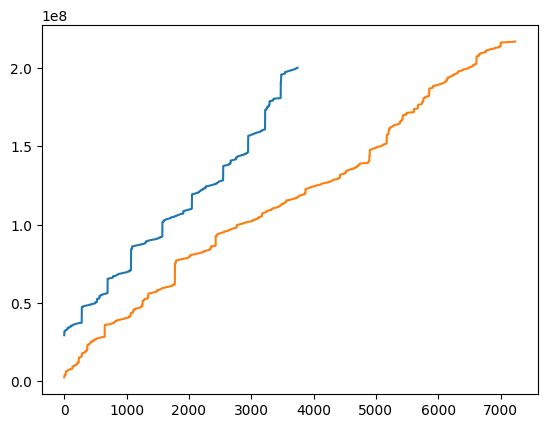

In [22]:
plt.plot(an1_times)
plt.plot(an_times)

In [12]:

def get_tracking_tones_verif(folder):
    all_files = glob.glob(os.path.join(folder, "tracking_0*.bin"))
    print(all_files)
    print(len(all_files))
    for file in all_files:
        print(file)
        print(extract_number_from_filename(file, 'tracking_'))
    all_files.sort(key=lambda x: extract_number_from_filename(x, 'tracking_'))
    # Print all matching files
    print("Files matching the pattern:")
    for file in all_files:
        print(file)
    all_tones, all_blocs = [], []
    for file in all_files:
        
        # Load the binary file into a NumPy array
        tones = np.fromfile(file, dtype=np.double)
        
        # Append the tones data to the list
        all_tones.append(tones)
        blocs = np.full(len(tones),extract_number_from_filename(file, 'tracking_'))
        all_blocs.append(blocs)
    return all_tones, all_blocs

def get_mock_tones_verif(folder):
    all_files = glob.glob(os.path.join(folder, "*mock_*.bin"))
    print(all_files)
    all_files.sort(key=lambda x: extract_number_from_filename(x, 'mock_'))
    # Print all matching files
    print("Files matching the pattern:")
    for file in all_files:
        print(file)
    all_tones, all_blocs = [], []
    for file in all_files:
        
        # Load the binary file into a NumPy array
        tones = np.fromfile(file, dtype=np.double)
        
        # Append the tones data to the list
        all_tones.append(tones)
        blocs = np.full(len(tones),extract_number_from_filename(file, 'mock_'))
        all_blocs.append(blocs)
    return all_tones, all_blocs

def get_playback_tones_verif(folder):
    # Find all files matching the pattern
    all_files = glob.glob(os.path.join(folder, "playback_*.bin"))

    # Print all matching files
    print("Files matching the pattern:")
    for file in all_files:
        print(file)

    # Sort files by the number extracted from their filename
    all_files.sort(key=lambda x: extract_number_from_filename(x, 'playback_'))

    all_tones, all_blocs = [], []
    for file in all_files:
        # Load the binary file into a NumPy array
        tones = np.fromfile(file, dtype=np.double)
        
        # Append the tones data to the list
        all_tones.append(tones)
        
        # Create an array filled with the file number
        blocs = np.full(len(tones), extract_number_from_filename(file, 'playback_'))
        all_blocs.append(blocs)

    return all_tones, all_blocs


In [13]:
playback, block = get_playback_tones_verif(path)

Files matching the pattern:
/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/playback_00_MUROLS_SESSION_00_20230220.bin
/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/playback_01_MUROLS_SESSION_00_20230220.bin
/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/playback_02_MUROLS_SESSION_00_20230220.bin
/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/playback_03_MUROLS_SESSION_00_20230220.bin
/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/playback_04_MUROLS_SESSION_00_20230220.bin
/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/playback_05_MUROLS_SESSION_00_20230220.bin
/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/playback_06_MUROLS_SESSION_00_20230220.bin
/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/playback_07_MUROLS_SESSION_00_20230220.bin
/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_

In [17]:
mock, block = get_mock_tones_verif(path)

['/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/tracking_mock_00_MUROLS_SESSION_00_20230220.bin', '/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/tracking_mock_01_MUROLS_SESSION_00_20230220.bin', '/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/tracking_mock_03_MUROLS_SESSION_00_20230220.bin', '/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/tracking_mock_04_MUROLS_SESSION_00_20230220.bin', '/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/tracking_mock_05_MUROLS_SESSION_00_20230220.bin', '/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/tracking_mock_06_MUROLS_SESSION_00_20230220.bin', '/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/tracking_mock_07_MUROLS_SESSION_00_20230220.bin', '/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/tracking_mock_08_MUROLS_SESSION_00_20230220.bin', '/auto/data2/eT

In [18]:
len(np.hstack(mock))

2378

In [20]:
3741+3742

7483

9861


In [147]:
extract_number_from_filename('/auto/data2/eTheremin/MUROLS/MUROLS_20230220/MUROLS_20230220_SESSION_00/tracking_05_MUROLS_SESSION_00_20230220.bin', 'tracking_')

5

In [76]:
import os

# Spécifie le chemin du dossier contenant les fichiers
#folder_path = path+'headstage_0/tones/'

# Parcours tous les fichiers du dossier
for filename in os.listdir(folder_path):
    # Construire le chemin complet des fichiers
    old_file_path = os.path.join(folder_path, filename)

    # Vérifie que c'est bien un fichier (et non un sous-dossier)
    if os.path.isfile(old_file_path):
        # Nouveau nom de fichier avec 'tones_' ajouté au début
        new_filename = "tones_" + filename
        new_file_path = os.path.join(folder_path, new_filename)

        # Renomme le fichier
        os.rename(old_file_path, new_file_path)
        print(f"Renommé : {filename} -> {new_filename}")

Renommé : tones_mock_04_ALTAI_SESSION_00_20240725.bin -> tones_tones_mock_04_ALTAI_SESSION_00_20240725.bin
Renommé : tones_playback_05_ALTAI_SESSION_00_20240725.bin -> tones_tones_playback_05_ALTAI_SESSION_00_20240725.bin
Renommé : tones_tracking_03_ALTAI_SESSION_00_20240725.bin -> tones_tones_tracking_03_ALTAI_SESSION_00_20240725.bin
Renommé : tones_tracking_05_ALTAI_SESSION_00_20240725.bin -> tones_tones_tracking_05_ALTAI_SESSION_00_20240725.bin
Renommé : tones_mock_02_ALTAI_SESSION_00_20240725.bin -> tones_tones_mock_02_ALTAI_SESSION_00_20240725.bin
Renommé : tones_tail_00_ALTAI_SESSION_00_20240725.bin -> tones_tones_tail_00_ALTAI_SESSION_00_20240725.bin
Renommé : tones_playback_01_ALTAI_SESSION_00_20240725.bin -> tones_tones_playback_01_ALTAI_SESSION_00_20240725.bin
Renommé : tones_playback_04_ALTAI_SESSION_00_20240725.bin -> tones_tones_playback_04_ALTAI_SESSION_00_20240725.bin
Renommé : tones_mock_01_ALTAI_SESSION_00_20240725.bin -> tones_tones_mock_01_ALTAI_SESSION_00_20240725.b

In [77]:
tt_path = path+'headstage_0/tt.pkl'
with open(tt_path, 'rb') as file:
    tt = pickle.load(file)

In [78]:
triggers = [elt for elt in tt['triggers'] ]
tones = [elt for elt in tt['tones'] ]
condition = [elt for elt in tt['condition']]
block = [elt for elt in tt['block']]
block = [int(elt[-1]) for elt in block]

In [79]:
block

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [66]:
import numpy as np

def extract_triggers_and_tones(triggers, tones, condition, block, condition_value, block_value):
    # Vérifie que les tableaux ont la même longueur
    
    # Trouver les indices où condition == condition_value et block == block_value
    indices = np.where((condition == condition_value) & (block == block_value))[0]
    # Extraire les valeurs correspondantes dans triggers et tones
    triggers_filtered = triggers[indices]
    tones_filtered = tones[indices]
    
    return triggers_filtered, tones_filtered


1


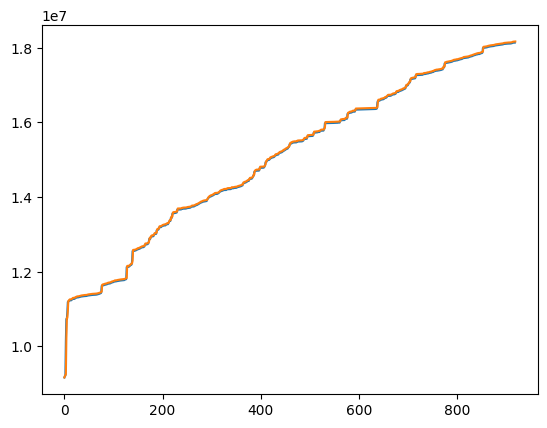

2


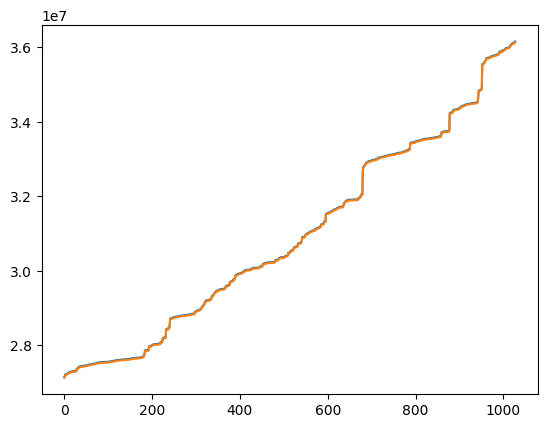

3


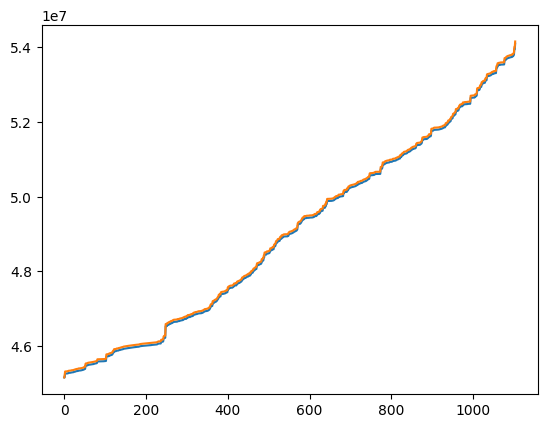

4


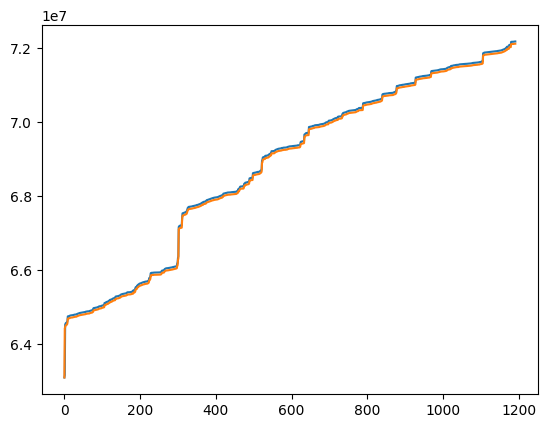

5


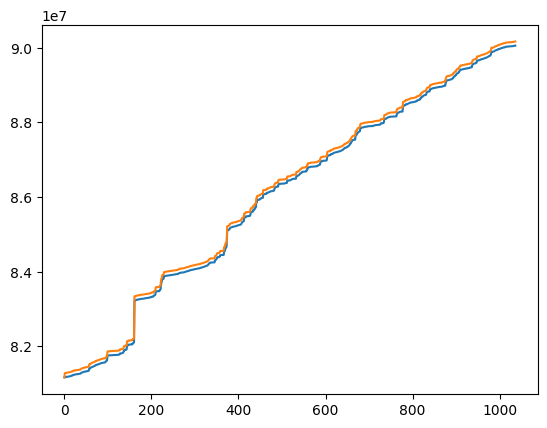

In [82]:
for b in range(1,6):   
    print(b)
    tr_tr, tr_tones = extract_triggers_and_tones(np.array(triggers), np.array(tones), np.array(condition), np.array(block), 0, b)
    tr_pb, tones_pb = extract_triggers_and_tones(np.array(triggers), np.array(tones), np.array(condition), np.array(block), 1, b)
    plt.plot(tr_tr)
    plt.plot(tr_pb-(tr_tr[-1]-tr_tr[0]))
    #plt.plot(tones_pb)
    #plt.plot(tr_tones)
    plt.show()

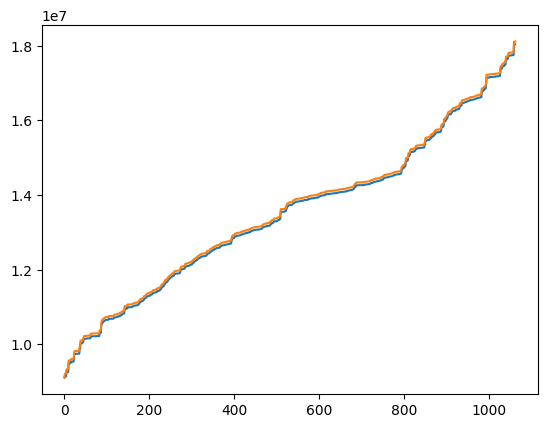

In [63]:
plt.plot(tr_tr)
plt.plot(tr_pb-(tr_tr[-1]-tr_tr[0]))

In [61]:
print(tr_tr)
print(tr_pb-(tr_tr[-1]-tr_tr[0]))

[ 9109784  9129584  9134104 ... 18027745 18034705 18035065]
[ 9109984  9204464  9208984 ... 18109786 18110146 18110306]


In [84]:
triggers_tr, tones_total_tr = get_triggers(path+'headstage_0/', analog_line=0)
triggers_pb, tones_total_pb = get_triggers(path+'headstage_0/', analog_line=1)

In [104]:
len(triggers_tr)-len(np.hstack(tones))

5168

In [88]:
len(tones_total_pb)

3744

In [94]:
def get_mock_tones_verif(folder):
    all_files = glob.glob(os.path.join(folder+'/tones/mock/', "*mock*.bin"))
    all_files.sort(key=lambda x: extract_number_from_filename(x, 'mock_'))
    # Print all matching files
    print("Files matching the pattern:")
    for file in all_files:
        print(file)
    all_tones, all_blocs = [], []
    for file in all_files:
        
        # Load the binary file into a NumPy array
        tones = np.fromfile(file, dtype=np.double)
        
        # Append the tones data to the list
        all_tones.append(tones)
        blocs = np.full(len(tones),extract_number_from_filename(file, 'mock_'))
        all_blocs.append(blocs)
    return all_tones, all_blocs

In [95]:
tones, block = get_mock_tones_verif(path+'headstage_0')

Files matching the pattern:
/auto/data2/eTheremin/MUROLS/MUROLS_20230219/MUROLS_20230219_SESSION_00/headstage_0/tones/mock/tones_tracking_mock_00_MUROLS_SESSION_00_20230219.bin
/auto/data2/eTheremin/MUROLS/MUROLS_20230219/MUROLS_20230219_SESSION_00/headstage_0/tones/mock/tones_tracking_mock_01_MUROLS_SESSION_00_20230219.bin
/auto/data2/eTheremin/MUROLS/MUROLS_20230219/MUROLS_20230219_SESSION_00/headstage_0/tones/mock/tones_tracking_mock_02_MUROLS_SESSION_00_20230219.bin
/auto/data2/eTheremin/MUROLS/MUROLS_20230219/MUROLS_20230219_SESSION_00/headstage_0/tones/mock/tones_tracking_mock_03_MUROLS_SESSION_00_20230219.bin
/auto/data2/eTheremin/MUROLS/MUROLS_20230219/MUROLS_20230219_SESSION_00/headstage_0/tones/mock/tones_tracking_mock_04_MUROLS_SESSION_00_20230219.bin
/auto/data2/eTheremin/MUROLS/MUROLS_20230219/MUROLS_20230219_SESSION_00/headstage_0/tones/mock/tones_tracking_mock_05_MUROLS_SESSION_00_20230219.bin
/auto/data2/eTheremin/MUROLS/MUROLS_20230219/MUROLS_20230219_SESSION_00/headst

In [100]:
len(np.hstack(tones))

4024

In [14]:
condition_tr = np.zeros(len(triggers_tr))
condition_pb = np.ones(len(triggers_pb))

In [15]:
trig_times = np.concatenate((triggers_tr, triggers_mc))
tones = np.concatenate((tones_total_tr, tones_total_mc))
condition = np.concatenate((condition_tr, condition_mc)) 

In [19]:
sorted_indices = np.argsort(trig_times[:len(tones)])

In [20]:
len(sorted_indices)

6397

In [21]:
sorted_indices = sorted_indices[:-1]
sorted_triggers = trig_times[sorted_indices]
sorted_tones = tones[sorted_indices]
sorted_condition = condition[sorted_indices]
block = creer_tableau_blocs(sorted_condition)


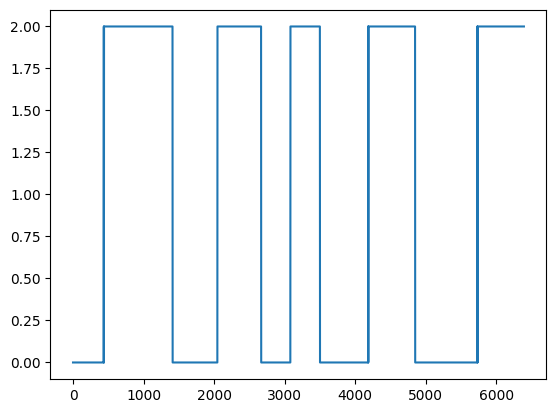

In [35]:
plt.plot(sorted_condition)

In [63]:
def creer_tableau_blocs(A):
    # Initialiser un tableau pour stocker les numéros de blocs
    blocs = np.zeros_like(A, dtype=int)  # Un tableau de la même taille que A, rempli de zéros
    bloc_courant = 0  # Compteur du bloc
    
    # Parcourir le tableau A
    for i in range(1, len(A)):
        # Si on passe de 0 à une valeur non-nulle, on démarre un nouveau bloc
        if A[i-1] != 0 and A[i] == 0 and A[i+1] == 0:
            print(A[i-1], A[i], A[i+1])
            bloc_courant += 1  # Nouveau bloc trouvé

        # Affecter le numéro du bloc courant aux éléments non-nuls
        if A[i] != 0:
            blocs[i] = bloc_courant
        else:
            blocs[i] = bloc_courant  # Les zéros appartiennent à aucun bloc (ou bloc zéro)
    
    return blocs

In [64]:
block = creer_tableau_blocs(sorted_condition)

2.0 0.0 0.0
2.0 0.0 0.0
2.0 0.0 0.0
2.0 0.0 0.0


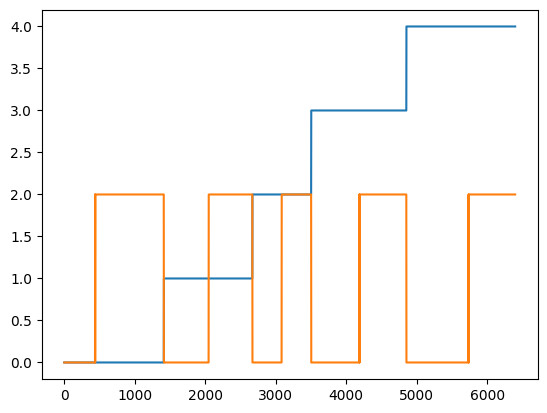

In [65]:
plt.plot(block)
plt.plot(sorted_condition)

In [27]:
json_path = find_json(path)
extracted_data = read_json_file(json_path)
tones, labels, mock_tones = concatenate_tones_and_labels(extracted_data, path+'headstage_0/tones')
condition, block = convert_condition_block(tones, labels)

In [29]:
extracted_data

[{'Block': 'Block_000',
  'Playback Mock_fn': None,
  'Playback Tones_fn': None,
  'Tracking Tones_fn': 'tones_tracking_00_ALTAI_SESSION_01_20240823.bin',
  'Mapping Change Tones_fn': 'tones_mc_00_ALTAI_SESSION_01_20240823.bin'},
 {'Block': 'Block_001',
  'Playback Mock_fn': None,
  'Playback Tones_fn': None,
  'Tracking Tones_fn': 'tones_tracking_01_ALTAI_SESSION_01_20240823.bin',
  'Mapping Change Tones_fn': 'tones_mc_00_ALTAI_SESSION_01_20240823.bin'},
 {'Block': 'Block_002',
  'Playback Mock_fn': None,
  'Playback Tones_fn': None,
  'Tracking Tones_fn': 'tones_tracking_02_ALTAI_SESSION_01_20240823.bin',
  'Mapping Change Tones_fn': 'tones_mc_00_ALTAI_SESSION_01_20240823.bin'},
 {'Block': 'Block_003',
  'Playback Mock_fn': None,
  'Playback Tones_fn': None,
  'Tracking Tones_fn': 'tones_tracking_03_ALTAI_SESSION_01_20240823.bin',
  'Mapping Change Tones_fn': 'tones_mc_00_ALTAI_SESSION_01_20240823.bin'},
 {'Block': 'Block_004',
  'Playback Mock_fn': None,
  'Playback Tones_fn': None,